In [ ]:
!pip install -q pytorch-lightning

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Change working directory
os.chdir('/content/drive/My Drive/NeuralCompression')

# Verify the change
print("Current working directory:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/My Drive/NeuralCompression


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pytorch_lightning as pl

import numpy as np
import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('medium')

In [ ]:
class PointDataset(Dataset):
    def __init__(self, data, num_batches=100, num_samples=10000):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.data = self.data / self.data.max()
        self.num_batches = num_batches
        self.num_samples = num_samples
        self.H, self.W, self.C = self.data.shape

        # Precompute indices and coordinates for efficiency
        self.precompute_indices_and_coordinates()

    def precompute_indices_and_coordinates(self):
        self.indices = []
        self.coordinates = []

        for _ in range(self.num_batches):
            indices = np.random.choice(self.H * self.W, self.num_samples, replace=False)
            indices_x = indices // self.W
            indices_y = indices % self.W
            coords = torch.tensor([indices_y / self.W, indices_x / self.H], dtype=torch.float32).T
            self.indices.append((indices_x, indices_y))
            self.coordinates.append(coords)

    def __len__(self):
        return self.num_batches

    def __getitem__(self, idx):
        indices_x, indices_y = self.indices[idx]
        coordinates = self.coordinates[idx]
        samples = self.data[indices_x, indices_y, :]
        return coordinates, samples

In [ ]:
# MLP = multi-layer perceptron
# neural networks don't have locations; MLP gives vector as input and vector as output; one layer is a linear layer (e.g. 3x1)
class NeuralFieldModel(pl.LightningModule):
    def __init__(self, lr=1e-2, encoding_levels=8):
        super().__init__()

        self.model = nn.Sequential( # do this stuff in the given order
            nn.Linear(2*2*encoding_levels + 2, 32), # matrix multiplication
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

        self.lr = lr
        self.encoding_levels = encoding_levels

    def frequency_encoding(self, x):
        # Create frequency encoding
        encodings = [x]
        for i in range(self.encoding_levels):
            encodings.append(torch.sin(2**i * np.pi * x))
            encodings.append(torch.cos(2**i * np.pi * x))
        return torch.cat(encodings, dim=-1)

    def forward(self, coordinates):
        coordinates = self.frequency_encoding(coordinates) #(y,x) -> (y,x,sin(x), cos(x), whatever)
        return self.model(coordinates)

    def training_step(self, batch, batch_idx):

        coordinates, samples = batch
        predictions = self.forward(coordinates)

        loss = (predictions - samples)**2
        #loss = abs(predictions - samples)
        loss = loss.mean()

        if batch_idx == 0:
            print("Training loss: ", loss.item())

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

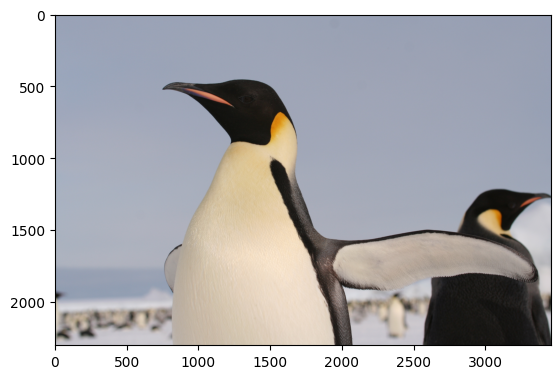

In [ ]:
img = plt.imread("emperorpenguin.jpg") / 255.0
plt.imshow(img)
plt.show()

In [ ]:
dataset = PointDataset(img, num_batches=30, num_samples=1000000) # intializes dataset and puts data into dataset a million samples (pixels), 10 batches per epoch
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, pin_memory=True, num_workers=2) # loads data into model; num_workers is # of helpers

<ipython-input-5-3b7a6d88e38c>:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  coords = torch.tensor([indices_y / self.W, indices_x / self.H], dtype=torch.float32).T


In [ ]:
model = NeuralFieldModel(lr=1e-2) #lr is your learning rate

In [ ]:
trainer = pl.Trainer(max_epochs=25, accelerator="gpu")
trainer.fit(model, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 9.6 K  | train
---------------------------------------------
9.6 K     Trainable params
0         Non-trainable params
9.6 K     Total params
0.038     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Training loss:  0.0006205591489560902
Training loss:  0.0036353340838104486
Training loss:  0.0020416302140802145
Training loss:  0.0014283318305388093
Training loss:  0.001086652628146112
Training loss:  0.0009102004114538431
Training loss:  0.000831715005915612
Training loss:  0.0007672816282138228
Training loss:  0.0007283767918124795
Training loss:  0.000701753597240895
Training loss:  0.0006865612813271582
Training loss:  0.0006472906679846346
Training loss:  0.0006773480563424528
Training loss:  0.0006031710654497147
Training loss:  0.000645836116746068
Training loss:  0.0005961994174867868
Training loss:  0.0005820348742417991
Training loss:  0.0005623038741759956
Training loss:  0.0006119820172898471
Training loss:  0.0005299184704199433
Training loss:  0.0005444356356747448
Training loss:  0.0005145954783074558
Training loss:  0.0005387489218264818
Training loss:  0.0004942913656122983
Training loss:  0.000491090991999954


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


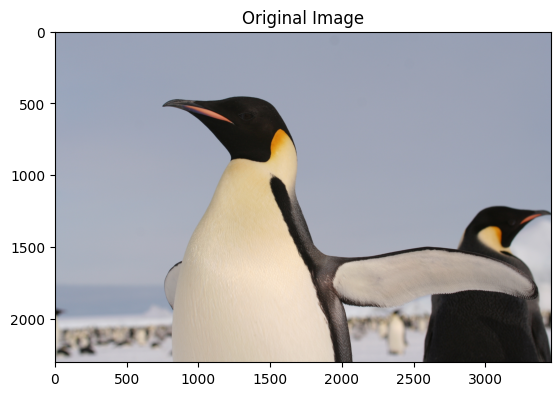

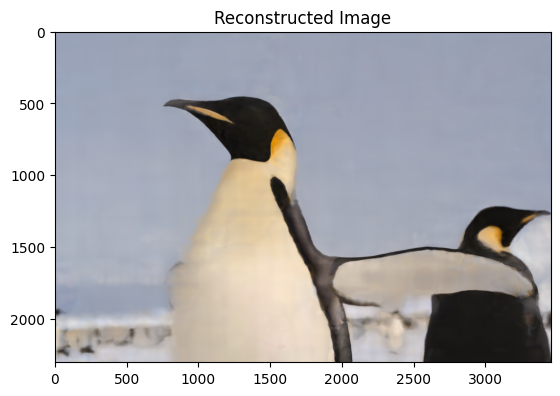

PSNR:  31.553316239004193
SSIM:  0.929411084216205


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def make_grid(H, W):
    # Create a grid of normalized coordinates
    y = np.linspace(0, 1, H)
    x = np.linspace(0, 1, W)
    grid_x, grid_y = np.meshgrid(x, y)
    coordinates = np.stack([grid_x.ravel(), grid_y.ravel()], axis=-1)
    coordinates = torch.tensor(coordinates, dtype=torch.float32)

    return coordinates

H, W = img.shape[0], img.shape[1]

coordinates = make_grid(H,W)
reconstruction = model(coordinates)
reconstruction = reconstruction.reshape(H,W,3).detach().cpu().numpy()

plt.imshow(img)
plt.title("Original Image")
plt.show()

plt.imshow(reconstruction)
plt.title("Reconstructed Image")
plt.show()

print("PSNR: ", psnr(img, reconstruction, data_range=1)) #higher PSNR the better, measure of how similar the colors of reconstructed img to original img; 30-40 is this the actual color
print("SSIM: ", ssim(img, reconstruction, channel_axis=2, data_range=1)) #structural similarity; how close the structure is (whether or not edges in images are aligned or not; below 0.9 is bad; want it to be around 1)

In [ ]:
coordinates

tensor([[0.0000e+00, 0.0000e+00],
        [2.8944e-04, 0.0000e+00],
        [5.7887e-04, 0.0000e+00],
        ...,
        [9.9942e-01, 1.0000e+00],
        [9.9971e-01, 1.0000e+00],
        [1.0000e+00, 1.0000e+00]])

In [ ]:
def get_model_size_megabytes(model): # returns the size of the model in megabytes
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    total_size = param_size + buffer_size  # in bytes
    total_size_megabytes = total_size / (1024 ** 2)  # convert bytes to megabytes
    return total_size_megabytes

def get_image_size_megabytes(array): # returns the size of the image in megabytes
    total_size_bytes = array.nbytes / 8  # total size in bytes (64 -> 8)
    total_size_megabytes = total_size_bytes / (1024 ** 2)  # convert bytes to megabytes
    return total_size_megabytes


In [ ]:
print("Image size: ", get_image_size_megabytes(img))
print("Model size: ", get_model_size_megabytes(model))
print("Compression Ratio:", get_image_size_megabytes(img) / get_model_size_megabytes(model))


NameError: name 'get_image_size_megabytes' is not defined